# **Bot de Processamento Automático de Mensagens no Telegram Parte 2**
Autor [Vinícius Oliveira](https://www.linkedin.com/in/vinicius-oliveira-p1/)

---

## **3\. ETL**

A etapa de **extração, transformação e carregamento** (ETL, do inglês *Extraction, Transformation, and Load*) é uma fase abrangente e fundamental para a **manipulação de dados** ingeridos a partir de sistemas transacionais, ou seja, dados que já foram **persistidos em camadas cruas** ou *raw* em sistemas analíticos.

Estrutura do Projeto

No projeto, as mensagens de cada dia, **armazenadas inicialmente na camada crua**, serão **compactadas em um único arquivo**, orientado a coluna e **comprimido**. Esse arquivo será então persistido em uma **camada enriquecida**, permitindo um armazenamento otimizado. Além disso, durante o processo de compactação, o dado passará pelas etapas de **data wrangling** mencionadas.

Para essa operação, utilizaremos uma **função do AWS Lambda** como motor de processamento e um **bucket do AWS S3** como camada enriquecida para a persistência dos dados processados. Para garantir que o processo seja recorrente, configuraremos uma **regra do AWS EventBridge** como gatilho diário para a função Lambda.


### **3\.1 AWS S3**

Agora iremos criar o bucket enriched do nosso projeto:

1. **Criar um bucket no AWS S3**: O primeiro passo é configurar o bucket que será utilizado para armazenar as mensagens processadas. Esse bucket funcionará como um armazenamento passivo dos dados em **arquivos diários no formato Parquet**.

2. **Nomear o bucket com o sufixo -enriched**: Como parte do padrão de nomenclatura para a camada enriquecida, adicionaremos o sufixo **-enriched** ao nome do bucket. Esse mesmo padrão será seguido para todos os serviços relacionados à camada de dados processados.


Criamos um Bucket enriched, onde iremos salvar os arquivos processados:

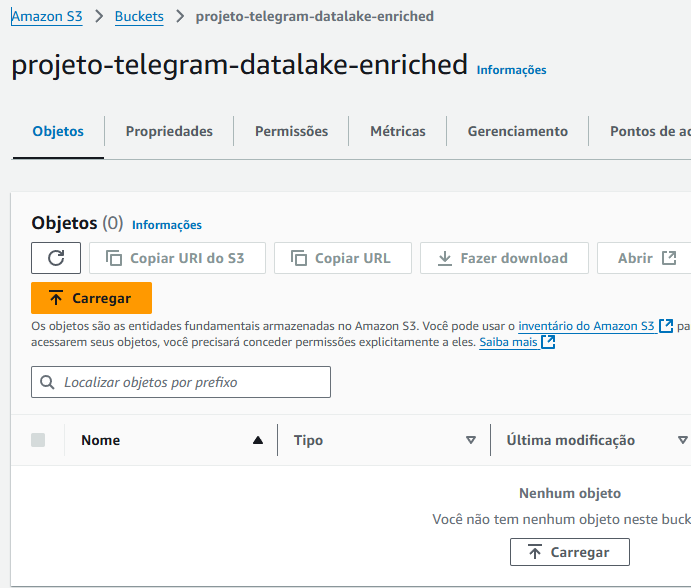

> Com o **bucket** criado, iremos para a parte de **processar os dados brutos** que temos.


### **3\.2 AWS Lambda enriched**

Na fase da função do **AWS Lambda** será processar ativamente as mensagens capturadas pelo bot do Telegram, que estão armazenadas na camada crua em um bucket do **AWS S3**. Após esse processamento, as mensagens serão persistidas na camada enriquecida, também em um bucket do S3. O fluxo do processo será o seguinte:

1. **Listagem de Arquivos**:
   - A função começará listando todos os arquivos JSON correspondentes a uma única participação na camada crua do bucket do AWS S3.

2. **Processamento de Cada Arquivo**:
   - **Download do Arquivo**: Cada arquivo listado será baixado para acesso ao seu conteúdo.
   - **Carregamento do Conteúdo**: O conteúdo das mensagens será carregado para o processamento.
   - **Data Wrangling**: Uma função de limpeza e transformação dos dados será aplicada para preparar as mensagens.
   - **Criação da Tabela com PyArrow**: Uma tabela será criada usando a biblioteca **PyArrow**, e essa tabela será concatenada com outras já processadas.

3. **Persistência dos Dados Enriquecidos**:
   - A tabela resultante do processamento será armazenada no formato **Parquet** na camada enriquecida, em um bucket do **AWS S3**.

**Observações**
- A implementação de duas camadas de armazenamento e processamento possibilita a reprocessamento dos dados brutos de várias maneiras, quantas vezes forem necessárias.
- A função será projetada para processar as mensagens do dia anterior (D-1).

Com esse fluxo, asseguramos um processamento eficiente e flexível das mensagens capturadas.


Para isso, iremos criar uma nova função **Lambda**, onde iremos inserir o seguinte código de **processamento**:


In [ ]:
'''
import os
import json
import logging
import boto3
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime, timedelta, timezone

def lambda_handler(event: dict, context: dict) -> bool:
    # Variáveis de ambiente
    RAW_BUCKET = os.environ["AWS_S3_BUCKET"]
    ENRICHED_BUCKET = os.environ["AWS_S3_ENRICHED"]

    # Configuração do fuso horário e data
    tzinfo = timezone(offset=timedelta(hours=-3))
    date = (datetime.now(tzinfo) - timedelta(days=1)).strftime("%Y-%m-%d")
    timestamp = datetime.now(tzinfo).strftime("%Y%m%d%H%M%S%f")

    # Inicialização do cliente S3
    client = boto3.client("s3")
    table = None

    try:
        # Listar arquivos no bucket de dados brutos
        response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f"telegram/context_date={date}")

        # Processar cada arquivo listado
        for content in response["Contents"]:
            key = content["Key"]
            local_file_path = f"/tmp/{key.split('/')[-1]}"

            client.download_file(RAW_BUCKET, key, local_file_path)

            with open(local_file_path, mode="r", encoding="utf8") as fp:
                data = json.load(fp)["message"]

            parsed_data = parse_data(data=data)
            iter_table = pa.Table.from_pydict(mapping=parsed_data)

            # Concatenar as tabelas
            if table:
              table = pa.concat_tables([table, iter_table])
            else:
              table = iter_table
              iter_table = None

        # Persistir a tabela enriquecida em formato Parquet
        parquet_file_path = f"/tmp/{timestamp}.parquet"
        pq.write_table(table=table, where=parquet_file_path)
        client.upload_file(parquet_file_path, ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")
        return True

    except Exception as exc:
        logging.error(f"Erro ao processar os dados: {exc}")
        return False
'''

Criamos a **função Lambda**, que será responsável por processar os dados brutos armazenados no **Bucket S3**. Essa função irá ler os arquivos JSON, realizar as transformações necessárias e armazenar os dados processados em um novo local para futuras análises.


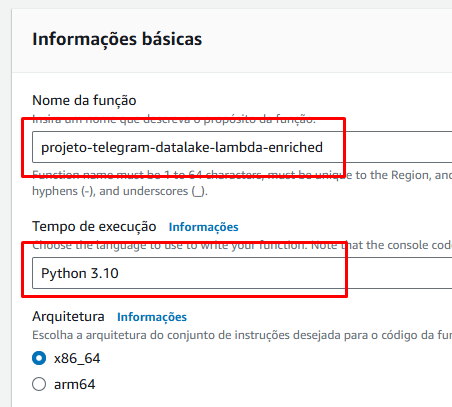

Com a **função Lambda** criada, iremos adicionar o código que desenvolvemos anteriormente e realizar o **deploy**:


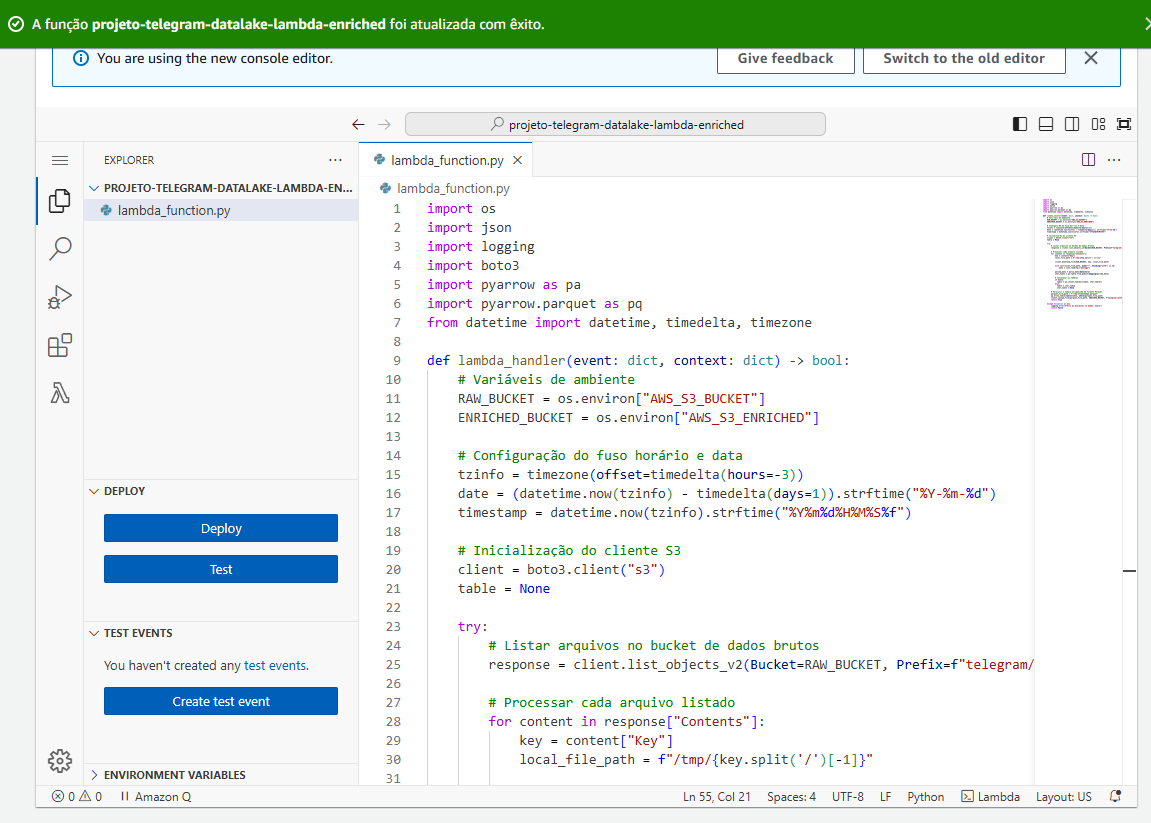

Após isso, devemos adicionar a função de **data wrangling** ao nosso código. Devemos inserir o código abaixo na mesma função **lambda** para que a função possa encontrar. Segue o código de wrangling abaixo:


In [ ]:
'''
def parse_data(data: dict) -> dict:

    # Obtendo a data e o timestamp atuais
    current_date = datetime.now().strftime("%Y-%m-%d")
    current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    parsed_data = dict()

    # Extração de dados relevantes
    for key, value in data.items():
        if key == "from":
            for sub_key, sub_value in value.items():
                if sub_key in ["id", "is_bot", "first_name"]:
                    parsed_data[f"user_{sub_key}"] = [sub_value]
        elif key == "chat":
            for sub_key, sub_value in value.items():
                if sub_key in ["id", "type"]:
                    parsed_data[f"chat_{sub_key}"] = [sub_value]
        elif key in ["message_id", "date", "text"]:
            parsed_data[key] = [value]

    # Garantir que a "text" esteja presente
    if "text" not in parsed_data:
        parsed_data["text"] = [None]
    return parsed_data
'''

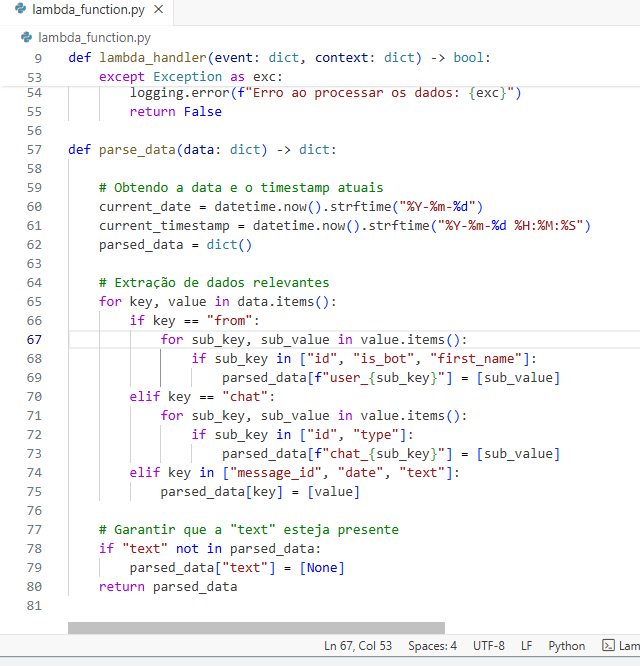

> Note que o código de **wrangling** deve estar na mesma função **lambda**.


Para fins de teste, será necessário ajustar a variável de **tempo** de 1 para 0. Essa alteração permitirá que os dados sejam processados no mesmo dia, facilitando a verificação do funcionamento da nossa função **Lambda**.


**Modificação do Código:**

A linha 16, que atualmente se encontra como:

```python
date = (datetime.now(tzinfo) - timedelta(days=1)).strftime("%Y-%m-%d")

Deverá ser alterada para:

date = (datetime.now(tzinfo) - timedelta(days=0)).strftime("%Y-%m-%d")


##### **Permissões**

Agora, para a função **Lambda** funcionar corretamente, devemos configurar nossas **variáveis de ambiente**, assim como no exemplo abaixo:


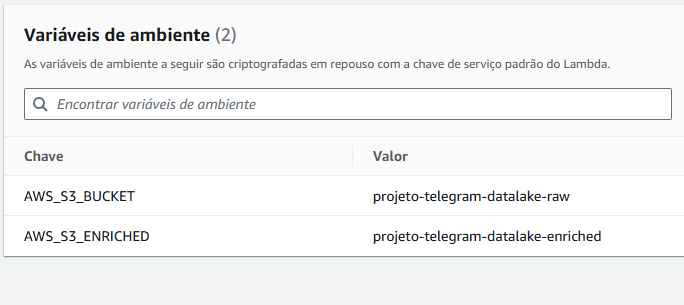

Feita a configuração das nossas **variáveis de ambiente**, temos que dar as devidas **permissões** para nossa função **Lambda** poder ler e escrever arquivos nos **buckets** do **S3**.


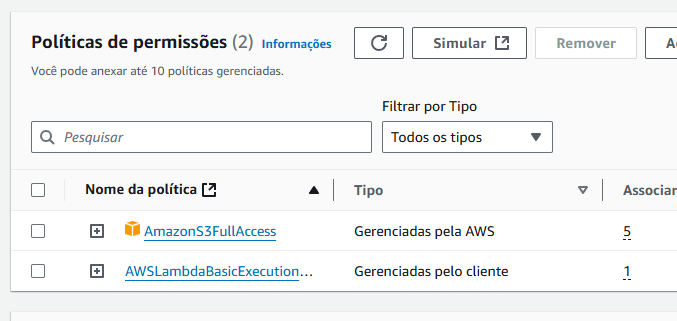

Com isso, concluímos a configuração da **política de acesso** da função **Lambda** e a configuração das **variáveis de ambiente**.


Considerando que nossa função envolve um volume significativo de **input** e **output**, é essencial que ajustemos o **tempo máximo de execução**. Caso contrário, o limite padrão poderá ser ultrapassado, resultando na classificação da função como **incompleta**. Para evitar essa situação, iremos modificar o tempo padrão para 5 minutos, assegurando assim que a função seja concluída adequadamente. Abaixo, apresentamos um exemplo de como essa configuração deverá ser implementada:


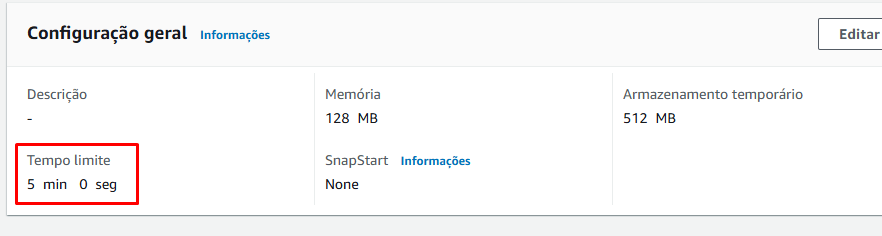

> Note que na **memória** e no **armazenamento temporário** não houve a necessidade de alterarmos, pois não irá ultrapassar a quantidade padrão.


Agora iremos configurar o **Layer** (camada) da nossa função **Lambda**. Para isso, iremos em **Camadas** e clicamos em **Adicionar camadas**.


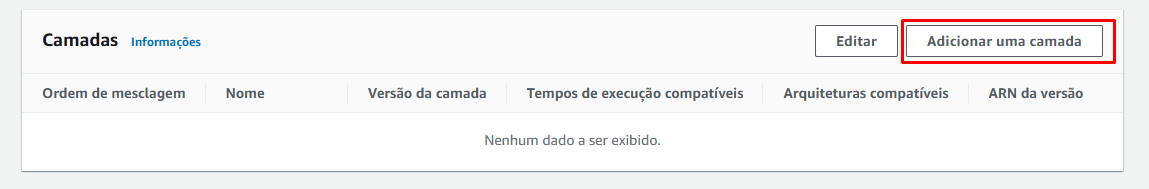

E, por fim, selecionamos **AWSSDKPandas-Python310** (ou a versão mais atual disponível), assim como no exemplo:


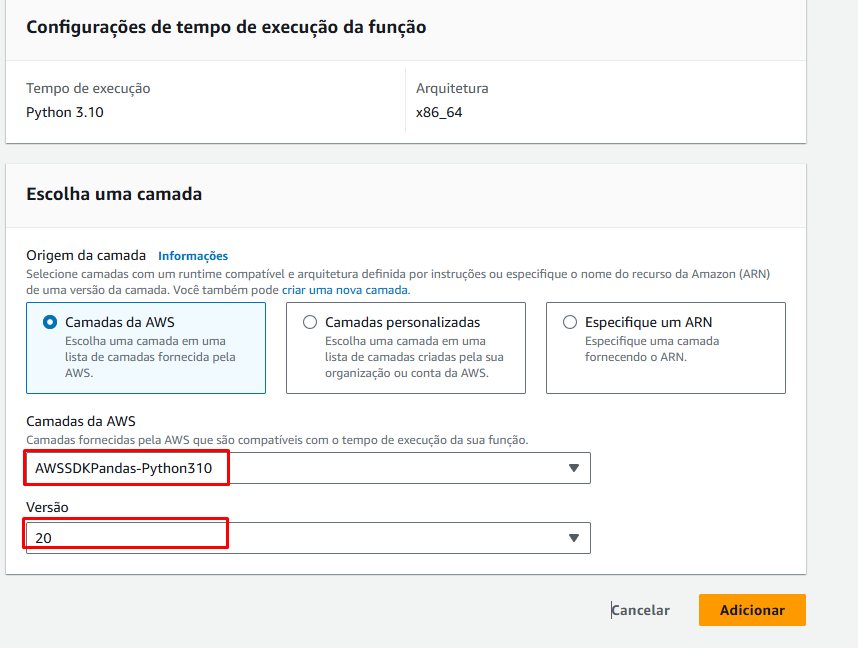

Feito isso, iremos para o **teste** da função. É importante garantir que todas as configurações e camadas foram aplicadas corretamente antes de prosseguir. Vamos verificar os resultados para confirmar que a função está operando conforme o esperado e, se necessário, realizar ajustes para otimizar seu desempenho.


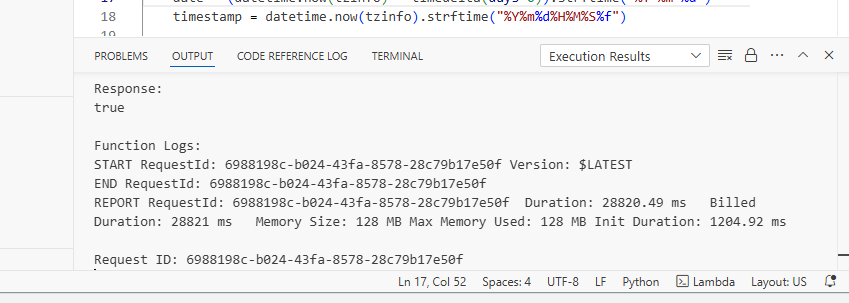

> Note que nossa função retornou um resultado **"True"**, o que indica que funcionou corretamente. Logo, é importante voltarmos a variável **"day"** para **"1"**, para que tudo funcione corretamente.


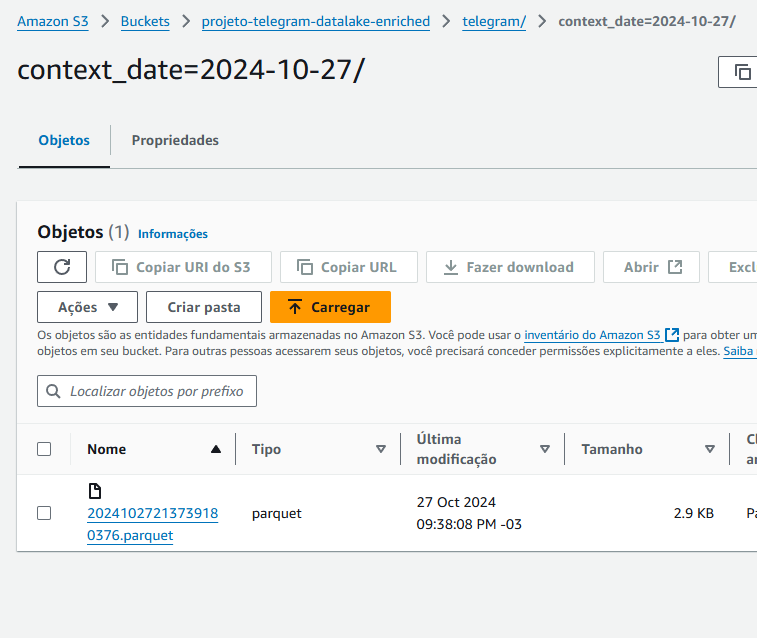

Confirmando novamente a funcionalidade do nosso código, podemos observar que no **bucket enriched** que criamos, o arquivo **Parquet** foi gerado corretamente. Ele contém as mensagens captadas do **Telegram**, que foram processadas de forma adequada.

Isso demonstra que nossa função **Lambda** está funcionando como esperado, garantindo que os dados sejam armazenados de maneira eficiente e acessível para futuras análises. É fundamental monitorar o desempenho contínuo e realizar testes adicionais conforme necessário para assegurar a integridade e a precisão dos dados.


### **3\.3 AWS Event Bridge**

Com tudo configurado, agora iremos ativar o **gatilho temporal** utilizando o **EventBridge**, para que nossa função **Lambda** seja acionada de acordo com o tempo que determinarmos. Essa configuração permitirá a execução automática da função em intervalos específicos, facilitando o processamento regular dos dados e garantindo que as operações sejam realizadas conforme a programação estabelecida.

Vamos seguir os passos para configurar o gatilho e garantir que a função esteja devidamente ativada.


Para isso, no **AWS EventBridge**, iremos em **Criar uma nova regra** e configurá-la de acordo com o exemplo abaixo:


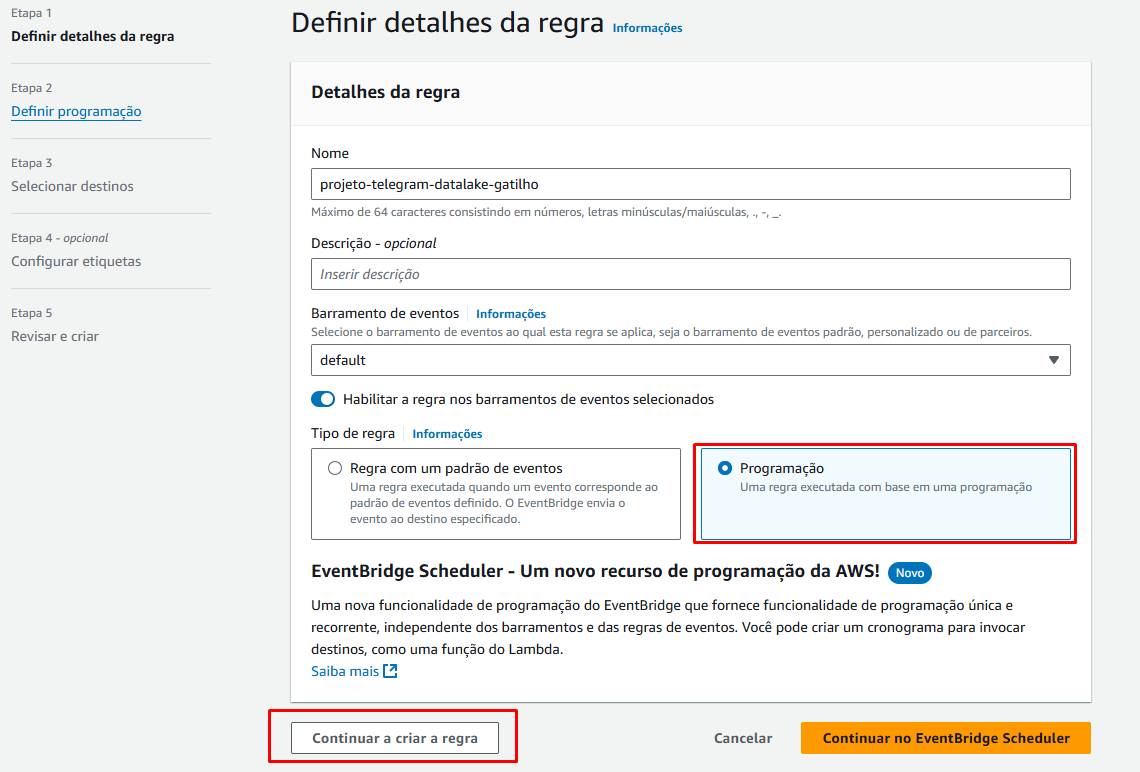

Feito isso, programamos uma **programação cron** de acordo com o exemplo:


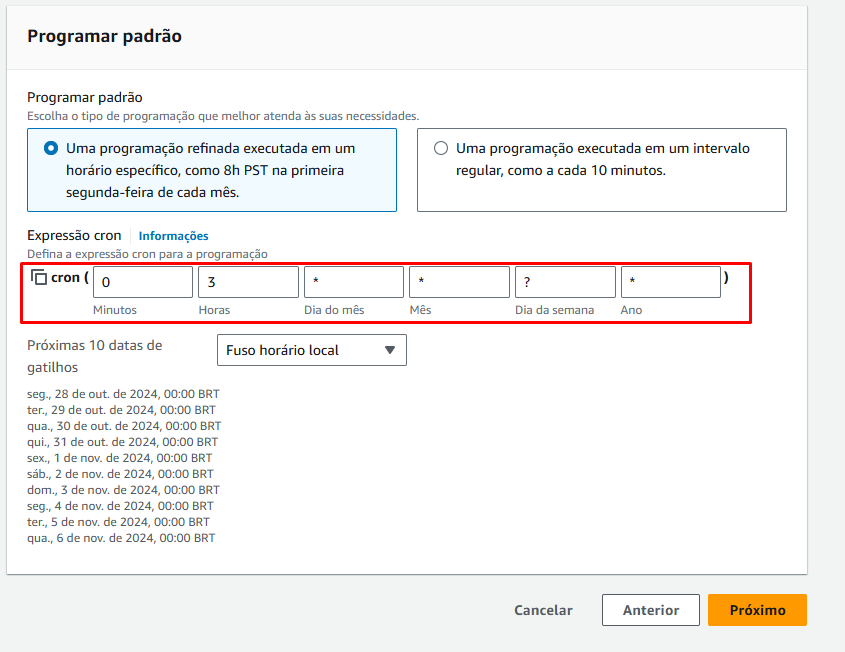

Após, iremos **indexar** o evento à nossa função **Lambda**:


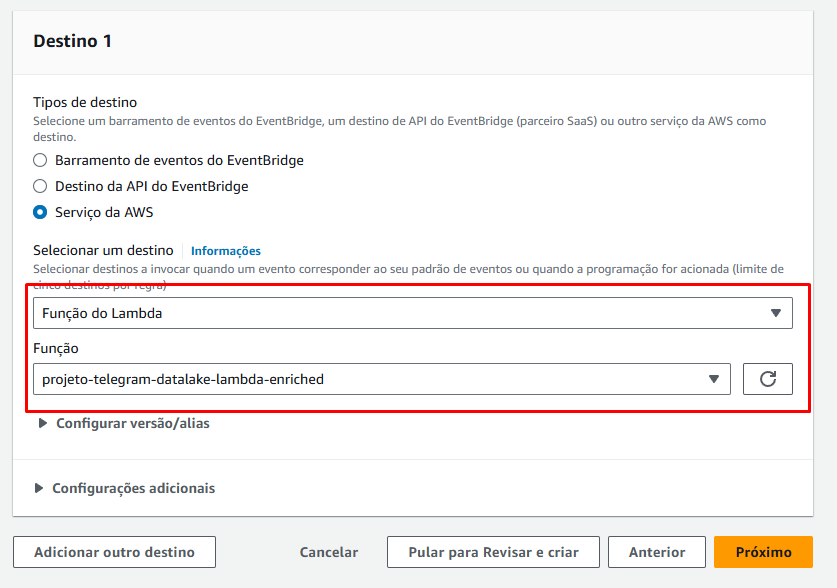

> Atente-se a escolher a função **Lambda** **enriched**.


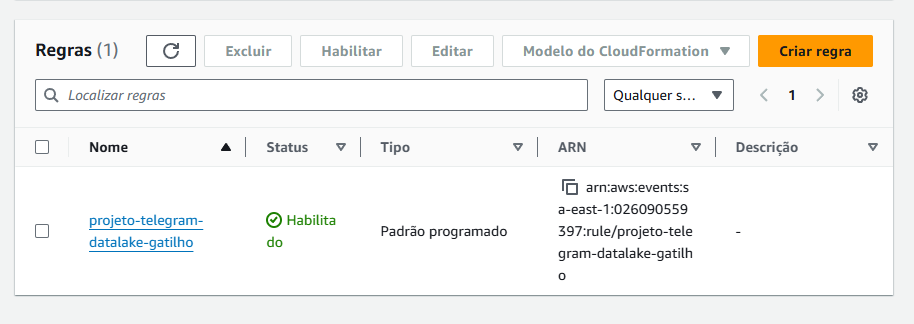

Feito isso, concluímos com sucesso toda a nossa programação do processamento dos dados brutos. Agora, os dados captados pelo **Telegram** foram processados e armazenados de maneira adequada.

Além disso, indexamos um período para a execução da função, garantindo que o processamento ocorra em intervalos regulares. Isso permitirá uma análise contínua e atualizada dos dados, aumentando a eficiência e a eficácia do nosso sistema.

É essencial monitorar o desempenho e a integridade dos dados, realizando ajustes conforme necessário para otimizar o fluxo de trabalho e assegurar que as operações sejam realizadas de acordo com as expectativas.


## **4\. Apresentação**

Agora iremos trabalhar e demonstrar as **visualizações** que conseguimos criar com os dados que processamos. Essas visualizações serão fundamentais para analisar os insights extraídos dos dados, facilitando a tomada de decisões informadas e a identificação de tendências relevantes.

#### **4\.1 AWS Athena**

Nesta etapa, iremos demonstrar, através do **AWS Athena**, uma interface de **query SQL** para representar uma arquitetura enriquecida dos nossos dados **Parquet**. Iremos apresentar a visualização particionada, que permitirá uma análise mais eficiente e eficaz dos dados processados.

A utilização do AWS Athena facilita a execução de consultas diretamente nos dados armazenados no **Amazon S3**, proporcionando insights valiosos de maneira rápida e escalável. Vamos explorar como estruturar nossas consultas para extrair as informações relevantes e apresentá-las de forma clara.


No **AWS Athena**, iremos utilizar o seguinte código na nossa **query SQL**:


In [ ]:
'''
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://projeto-telegram-datalake-enriched/telegram/'
'''

"\nCREATE EXTERNAL TABLE `telegram`(\n  `message_id` bigint,\n  `user_id` bigint,\n  `user_is_bot` boolean,\n  `user_first_name` string,\n  `chat_id` bigint,\n  `chat_type` string,\n  `text` string,\n  `date` bigint)\nPARTITIONED BY (\n  `context_date` date)\nROW FORMAT SERDE\n  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'\nSTORED AS INPUTFORMAT\n  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'\nOUTPUTFORMAT\n  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'\nLOCATION\n  's3://<bucket-enriquecido>/'\n"

> Note que é importante você selecionar o **bucket enriched** e colocar corretamente o caminho especificado até a pasta **Telegram**.


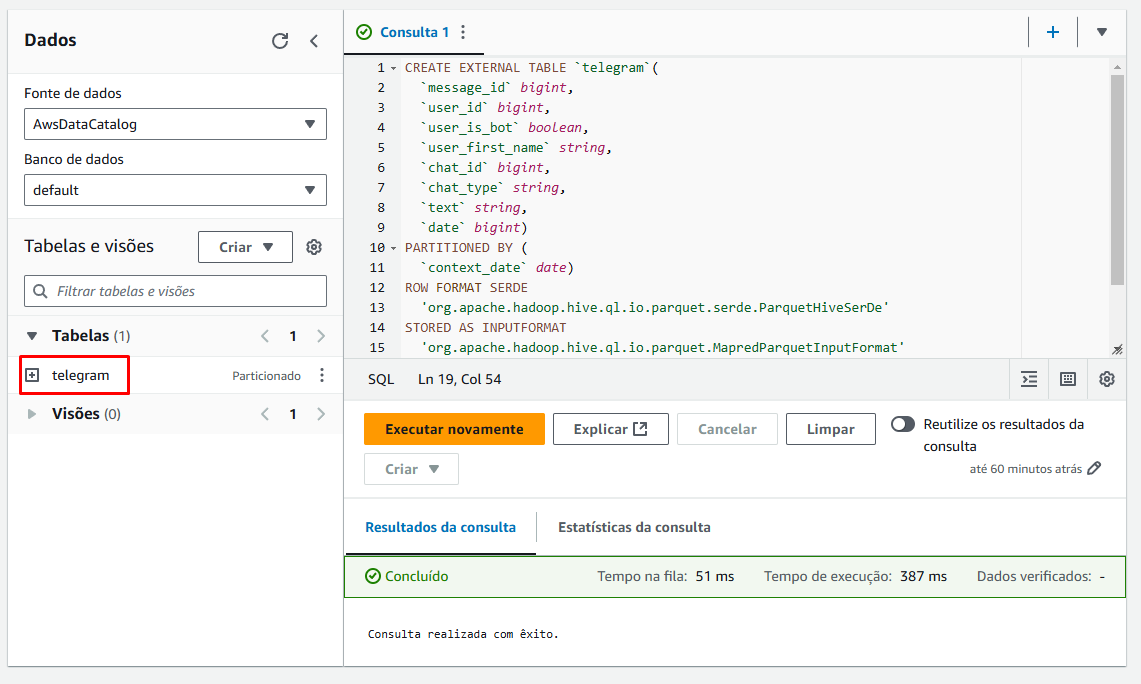

Após criarmos nossa tabela **Telegram**, iremos carregar as **partições** dos nossos dados **Parquet**:


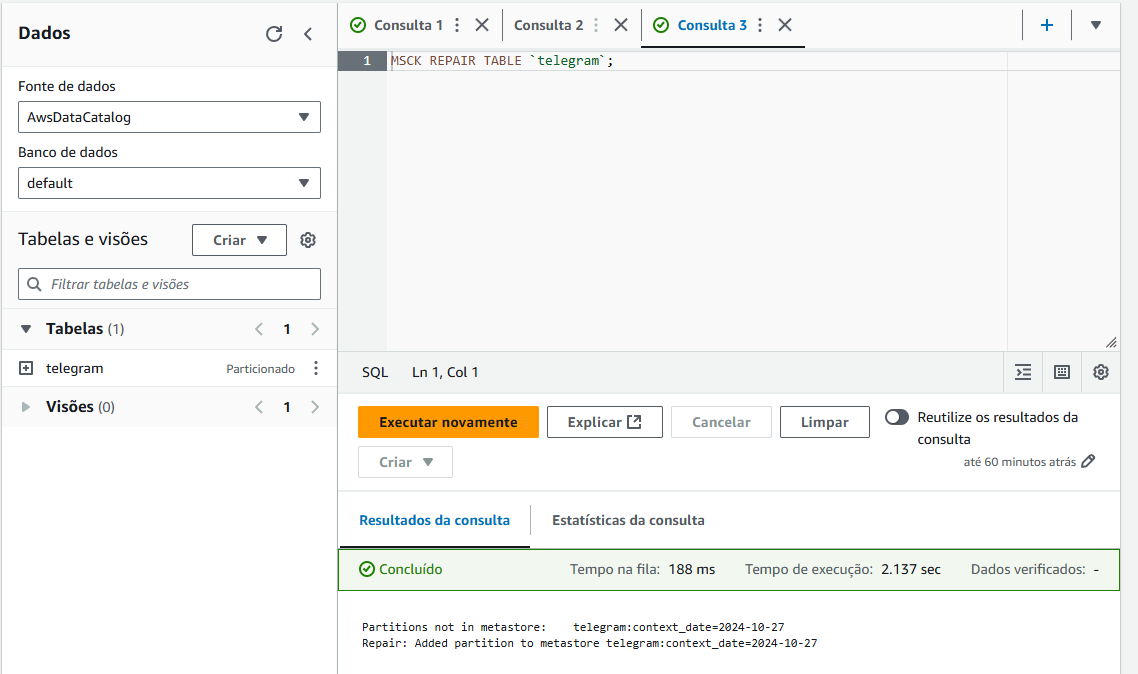

> **Importante**: Sempre que uma nova partição for adicionada ao repositório de dados, é necessário notificar o **AWS Athena** para que a partição fique disponível para consultas SQL. Para isso, utilize o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para atualizar todas as partições (mais custo computacional) ou, para adicionar apenas uma partição específica (mais econômico), o comando `ALTER TABLE <nome-tabela> ADD PARTITION (<coluna-partição> = <valor-partição>)`. Consulte a [documentação completa aqui](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html).


Agora, para confirmarmos que nossos dados foram realmente adicionados à nossa tabela, faremos uma consulta para verificar se os dados foram preenchidos corretamente:


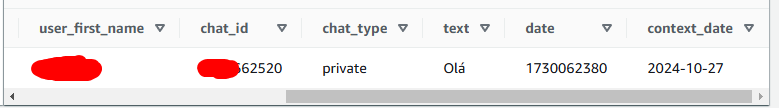

> Note que **"user_first_name"** e **"chat_id"** foram preservados para a privacidade dos usuários.


#### **4\.2 Analytics**

Com os dados particionados e organizados em formato SQL, executamos uma série de consultas analíticas que permitiram extrair insights valiosos sobre o comportamento dos usuários no **Telegram**:

- **Quantidade de mensagens por dia**
- **Quantidade de mensagens por usuário por dia**
- **Média do tamanho das mensagens por usuário por dia**
- **Distribuição de mensagens por hora ao longo dos dias da semana**

Essas consultas possibilitam entender padrões de uso e atividade dos usuários, fornecendo uma visão detalhada e em tempo real das interações no grupo.


- **Quantidade de mensagens por dia:** Esta métrica nos permite acompanhar o volume total de mensagens enviadas em cada dia, ajudando a identificar tendências e picos de atividade. Ao analisar essa informação, podemos entender melhor os momentos de maior interação no grupo e ajustar estratégias de engajamento conforme necessário.


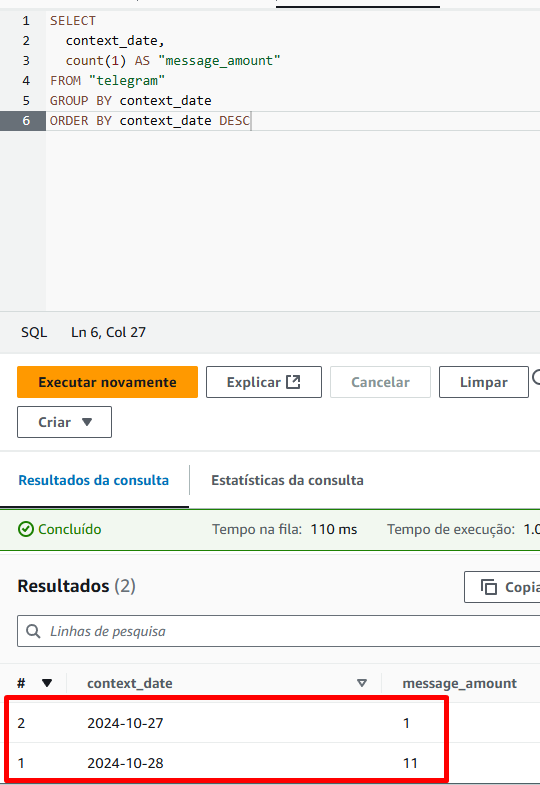

- **Quantidade de mensagens por usuário por dia:** Essa métrica nos permite analisar o engajamento individual de cada usuário, mostrando quantas mensagens cada um enviou diariamente. Com isso, podemos identificar usuários mais ativos, entender padrões de participação e, se necessário, implementar estratégias para aumentar a interação de usuários menos ativos.


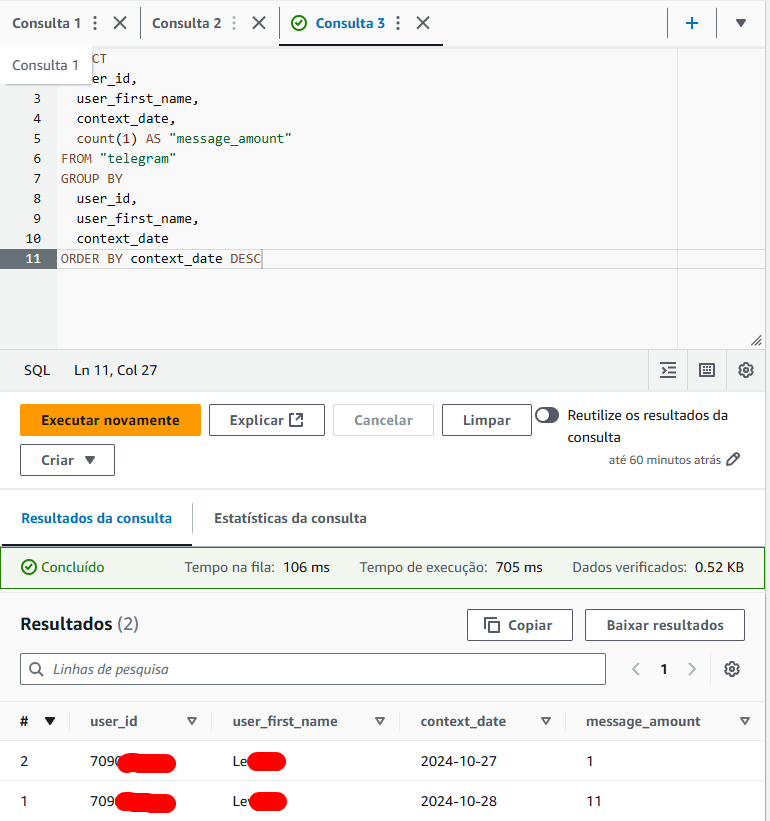

- **Média do tamanho das mensagens por usuário por dia:** Essa métrica nos ajuda a entender não apenas a quantidade de mensagens enviadas, mas também a profundidade das interações. Ao calcular a média do tamanho das mensagens, podemos identificar se os usuários estão enviando mensagens mais curtas ou longas ao longo do tempo. Isso pode indicar o tipo de engajamento que estão tendo, além de permitir a análise de temas ou tópicos que geram respostas mais elaboradas.


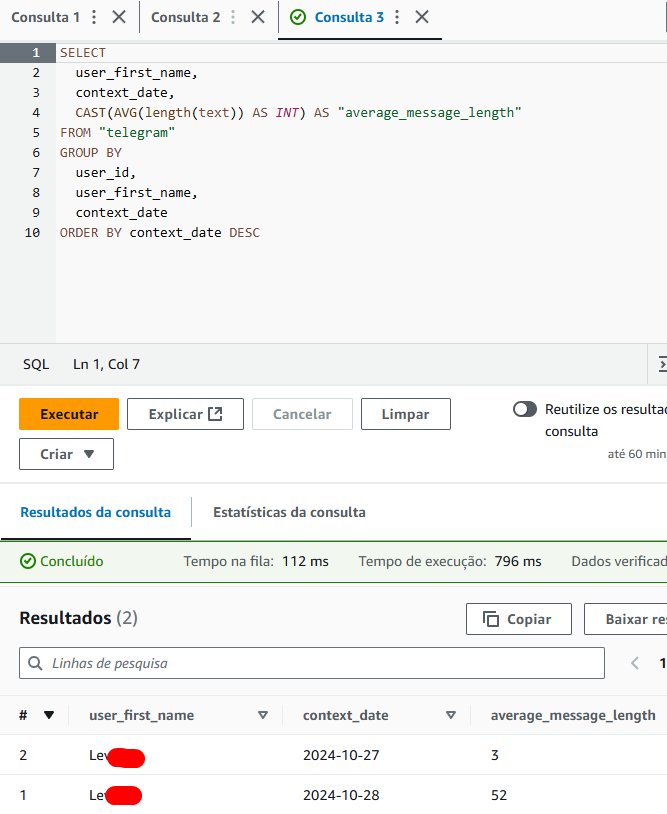

- **Quantidade de mensagens por hora por dia da semana por número da semana:** Esta métrica fornece uma visão detalhada da distribuição de mensagens ao longo do tempo, permitindo identificar padrões de atividade por hora em cada dia da semana. Com essa análise, podemos detectar horários de pico e dias com maior interação, o que é essencial para entender comportamentos e preferências dos usuários. Essas informações podem ser úteis para otimizar a programação de postagens ou eventos, aumentando o engajamento durante os períodos mais ativos.


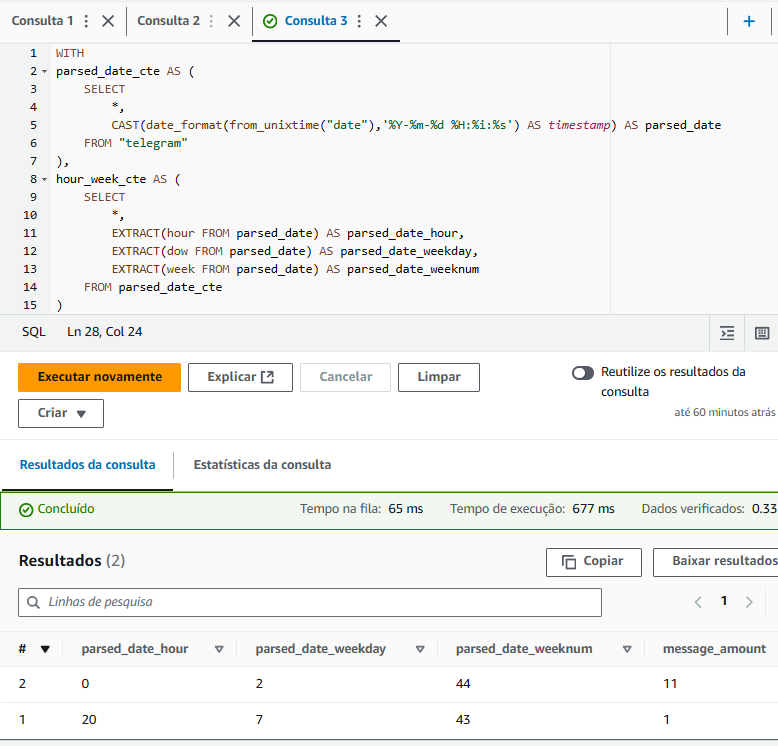

## **5. Conclusão**

Neste projeto, implementei um pipeline de dados robusto e automatizado para captura, processamento e análise de conversas do Telegram, utilizando uma arquitetura serverless com ferramentas da AWS. A solução foi desenvolvida para ser altamente escalável e eficiente em custos, garantindo o processamento contínuo dos dados sem a necessidade de gerenciar uma infraestrutura física.


1. **Ingestão de Dados**: Configurei um bot no Telegram para capturar mensagens e redirecioná-las a uma API desenvolvida com o **AWS API Gateway**. Em seguida, utilizei uma **função AWS Lambda** para armazenar os dados em um bucket S3, garantindo que eles fossem salvos em seu formato original (JSON), o que facilita o reprocessamento e manutenção de um histórico integral.

2. **Armazenamento e Transformação**: Após a ingestão, implementei um processo ETL (Extract, Transform, Load) que se inicia automaticamente sempre que novos dados são armazenados no S3. Por meio de um segundo Lambda e **AWS EventBridge**, consegui garantir o fluxo automatizado dos dados para transformação e armazenagem em um bucket S3 enriquecido, usando o formato Parquet, ideal para consultas e análises rápidas.

3. **Consultas e Análises com Athena**: Com os dados particionados e organizados no formato Parquet, configurei o **AWS Athena** para realizar consultas SQL sobre o dataset. Essa etapa permite insights analíticos diretamente na interface do Athena, onde executei consultas para gerar informações como quantidade de mensagens por dia, padrão de mensagens por semana, e média do tamanho das mensagens por usuário.

4. **Visualizações e Integrações**: Os dados enriquecidos e organizados em tabelas externas facilitaram uma análise mais profunda e a criação de visualizações que permitem monitorar o comportamento dos usuários no Telegram.

Cada etapa do pipeline foi cuidadosamente configurada para garantir que os dados fossem armazenados de maneira organizada, usando o formato Parquet para otimização e partição dos dados. O uso do AWS Athena permite consultas SQL rápidas e detalhadas, transformando o projeto em uma solução poderosa para monitoramento e análise em tempo real.

Esse projeto não só atendeu ao objetivo inicial de capturar dados do Telegram e transformá-los em insights valiosos, mas também provou ser uma base sólida e expansível para futuras análises e integrações de dados. Ele representa uma aplicação avançada de ferramentas e práticas de engenharia de dados, capaz de ser adaptada para uma variedade de contextos e necessidades.
